# Optimizer
Gets data and uses it to optimize a method (imported from method.py) using a loss function and tests it against unseen data
TODO:
- How am I calculation loss (sometimes test loss lower than train)
- SVM


In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
import torch
import torch.optim as optim
import seaborn as sns

# Import data

In [107]:
### Load the data
seed = 42 # 12: test better as train
data_path = 'data/output/data_complete_2022-06-14.csv'
df = pd.read_csv(data_path)

# Scale Data

In [108]:
df.drop(columns='dataset')

,Outside Temperature,Avg. Temperature,RH,va,Tg,Gender,Age,Height,Weight,Duration,Icl,Thermal feeling (global)
0,15.69,18.560,73.440,0.040,17.870,0,23,169,74,7.5,1.06280,-2
1,15.59,19.185,74.410,0.155,18.125,1,18,186,105,22.5,0.82065,0
2,15.69,19.580,73.255,0.020,18.905,0,33,160,45,7.5,0.72045,0
3,15.69,19.105,73.275,0.240,18.155,0,26,167,59,7.5,0.65365,-1
4,15.69,19.050,77.180,0.240,18.620,0,47,172,70,7.5,0.74550,2
...,...,...,...,...,...,...,...,...,...,...,...,...
273,8.10,18.265,58.815,0.070,19.625,1,34,186,78,12.5,1.07115,0
274,7.90,18.265,58.885,0.070,19.625,0,26,172,64,12.5,1.24650,1
275,7.90,17.325,58.420,0.080,19.155,1,26,180,85,10.0,1.27155,0
276,7.70,17.020,69.170,0.070,16.690,1,27,185,95,2.5,1.09620,-1


In [109]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
M = scaler.fit_transform(df.drop(columns='dataset'))
M = df.drop(columns='dataset').to_numpy()
y = M[:,-1]
#y = df['Thermal comfort (global)']
X = M[:,:-1]

# Train

In [110]:
import time
from torch.optim.lr_scheduler import ExponentialLR
from methods import *
from torch import nn

import numpy as np
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

test_values = []
predicted_values = []
datasets = []
# Test split using K-Folds cross-validator
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    # Slicing data according to kf split
    dtype = torch.float
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Hyper-parameters for one train test session
    torch.manual_seed(seed)
    method = SVM(input_size=x_train.shape[1])

    if method.optimizes:
        x_train = torch.tensor(x_train,dtype=dtype)
        x_test = torch.tensor(x_test, dtype=dtype)
        y_test = torch.tensor(y_test, dtype=dtype).reshape(-1,1)
        y_train = torch.tensor(y_train, dtype=dtype).reshape(-1,1)

        criterion = nn.MSELoss()
        params_to_be_optimized = method.get_parameters()
        optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
        #scheduler = ExponentialLR(optimizer, gamma=0.999)
        train_losses = []  # for plot
        test_losses = []  # for plot

        epochs = 100
        for epoch in range(epochs):
          iteration_time = time.time()
          optimizer.zero_grad()

          # forward pass
          y_train_predicted = method.predict(x_train)
          loss = criterion(y_train_predicted, y_train)

          # backward pass
          loss.backward()
          optimizer.step()
          #scheduler.step()

          with torch.no_grad():
            y_train_predicted = method.predict(x_train)
            train_loss = criterion(y_train_predicted, y_train)
            train_losses.append(train_loss)

            y_test_predicted = method.predict(x_test)
            test_loss = criterion(y_test_predicted, y_test)
            test_losses.append(test_loss)

        plt.plot(train_losses, label='train loss')
        plt.plot(test_losses, label='test loss')
        plt.legend()
        plt.title(f'K = {idx}')
        plt.show()

            # Lists for Error Analysis df
        test_values += y_test.detach().numpy().reshape(-1).tolist()
        predicted_values += method.predict(x_test).detach().numpy().reshape(-1).tolist()
        datasets += df['dataset'][test_index].tolist()

    else:
        method.fit(x_train,y_train)
        test_values += y_test.tolist()
        predicted_values += method.predict(x_test).tolist()
        datasets += df['dataset'][test_index].tolist()

# Test Analysis

In [111]:
analysis_df = pd.DataFrame({'dataset':datasets, 'y': test_values, 'pred': predicted_values})
analysis_df['error'] = analysis_df['y']-analysis_df['pred']
analysis_df['error_abs'] = np.abs(analysis_df['error'])
analysis_df['error_%'] = analysis_df['error_abs'] /analysis_df['y']

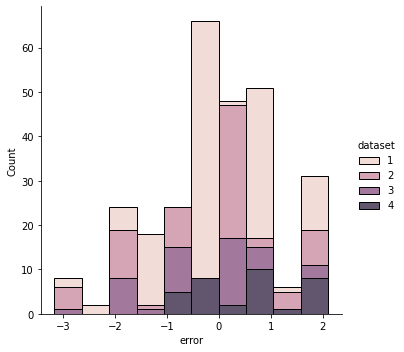

In [112]:
sns.displot(data=analysis_df, x="error", hue="dataset", multiple="stack")
plt.show()

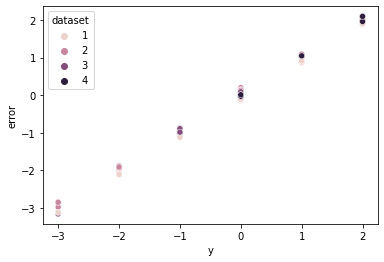

In [113]:
sns.scatterplot(data=analysis_df, x="y", y="error", hue="dataset")
plt.show()

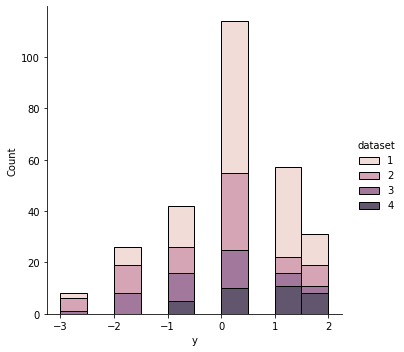

In [114]:
sns.displot(data=analysis_df, x="y", hue="dataset", multiple="stack")
plt.show()